In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from hyperspectral import *
import numpy as np
import pickle

hsi_import = np.load('data/hsi_data.npz')
hsi_data = hsi_import['hyperspectral_data']
wavelengths = hsi_import['wavelengths']

model_imoprt = pickle.load(open('data/trained_regressor.p', 'rb'))
observations = model_imoprt['observations']
targets = model_imoprt['targets']
regression_model = model_imoprt['model']
predictions = regression_model.predict(observations)

#### Plotting Spectra w/ Varying Qualities of Fit ####

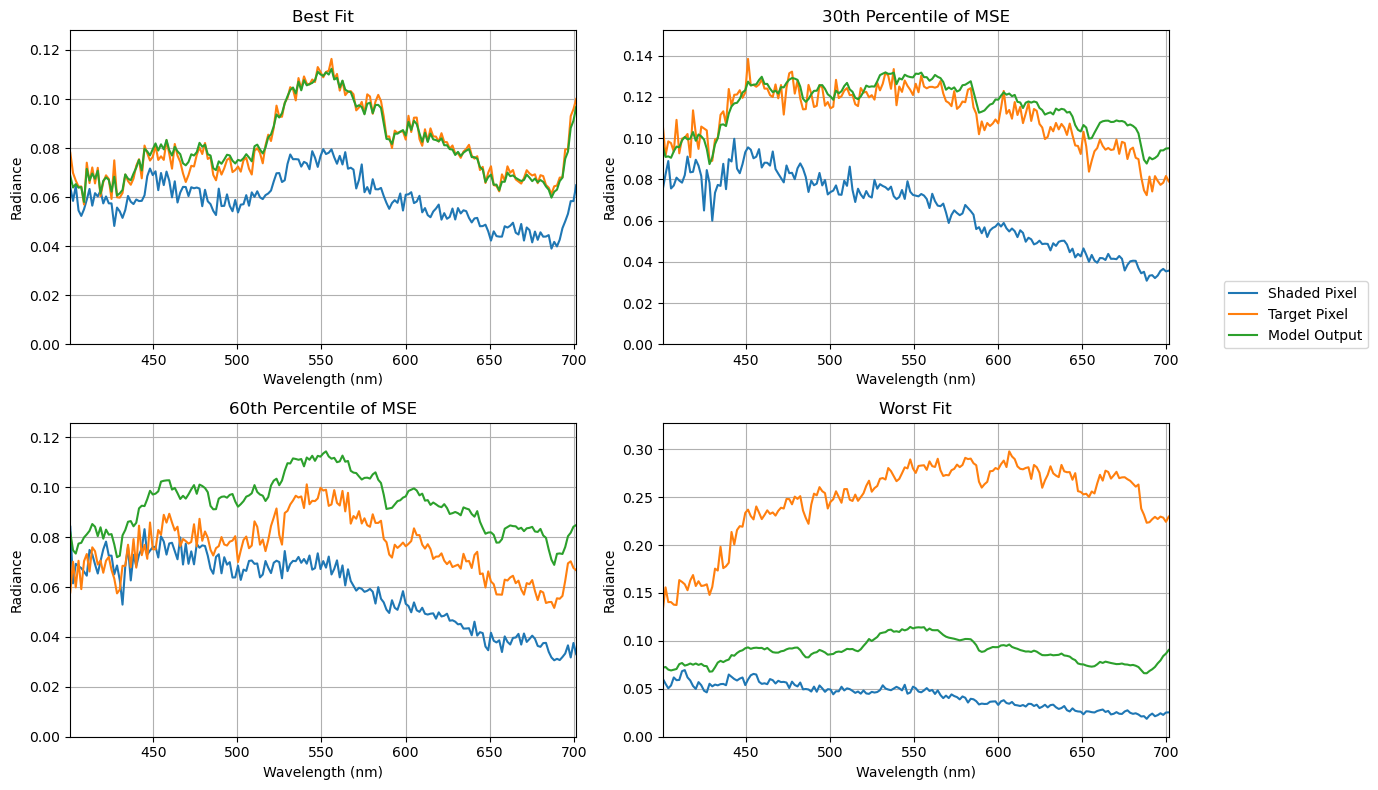

In [4]:
num_targets = targets.shape[0]
mse_values = [ np.sum((predictions[i, :] - targets[i,:])**2) for i in range(num_targets) ]

mse_sorted_indices = np.argsort(mse_values)
plot_indices = [mse_sorted_indices[0], mse_sorted_indices[int(0.3 * num_targets)], 
                mse_sorted_indices[int(0.6 * num_targets)], mse_sorted_indices[-1]]

fig, axs = plt.subplots(2,2,figsize=(12,8))

for obs, ax, name in zip(plot_indices, [(0,0), (0,1), (1,0), (1,1)], ['Best Fit', '30th Percentile of MSE', '60th Percentile of MSE', 'Worst Fit']):
    axs[ax].title.set_text(name)
    spectra_plot(axs[ax], wavelengths, np.array([observations[obs,:], targets[obs,:], predictions[obs,:]]))

plt.tight_layout()
plt.figlegend(labels=['Shaded Pixel', 'Target Pixel', 'Model Output'], loc='right', bbox_to_anchor=(1.15, 0.6))
plt.show()

#### Applying to Whole Scene ####

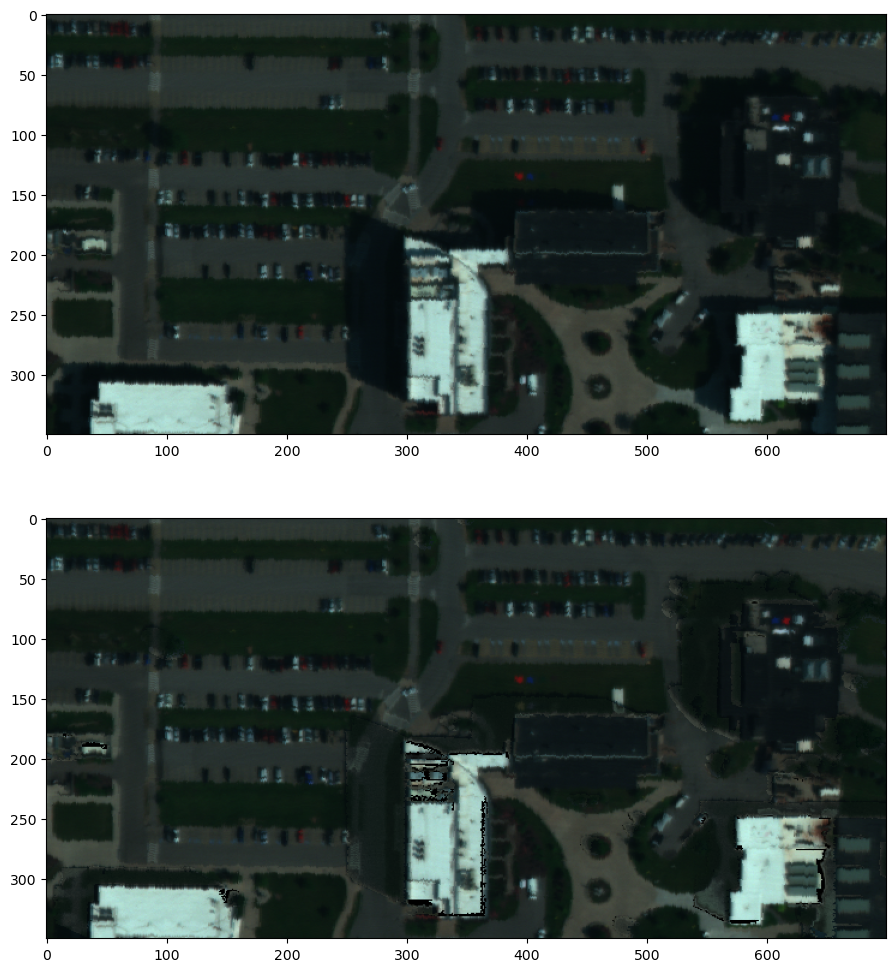

In [6]:
lidar_import = np.load('data/lidar_data.npz')
shadow = lidar_import['shadow']

shadow = shadow.flatten()
hsi_data_matrix = multispectral_raster_to_matrix(hsi_data)

pixels_to_attenuate = hsi_data_matrix[shadow,:]
hsi_data_matrix[shadow,:] = regression_model.predict(pixels_to_attenuate)
hsi_data_matrix[hsi_data_matrix < 0.0] = 0.0
hsi_data_matrix[hsi_data_matrix > 1.0] = 1.0

hsi_data_updated = hsi_data_matrix.reshape(hsi_data.shape)
plt.figure(figsize=(18,12))
plt.subplot(211)
plt.imshow(multispectral_raster_to_rgb(hsi_data, wavelengths))
plt.subplot(212)
plt.imshow(multispectral_raster_to_rgb(hsi_data_updated, wavelengths))
plt.show()